In [1]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from imageio import imread, imwrite
from skimage.transform import resize
import PIL
sys.path.append('..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, MobileNet,DenseNet121, ResNet50, VGG19, MobileNet_v2, InceptionResNet_v2


plt.style.use('seaborn-poster')
plt.style.use('ggplot')

shape_to_feed = (120, 120)

images_folder = "/home/grisha/work/meters/newone/data/images"
labels_folder = "/home/grisha/work/meters/newone/data/labels"

clean_images_folder = "/home/grisha/work/meters/newone/data/images_clean"

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocess images

In [2]:
def remove_background(image, bbox):
    """ Removes white stripes from the edges of an image."""
    rows_mean, columns_mean = image.mean((1, 2)), image.mean((0, 2))
    rows_nonwhite = np.argwhere(rows_mean < 250)
    columns_nonwhite = np.argwhere(columns_mean < 250)

    new_bbox = bbox.copy()

    dr, dc = 0, 0
    if rows_mean[0] > 250:
        dr = rows_nonwhite[0][0]
        
    if columns_mean[0] > 250:
        dc = columns_nonwhite[0][0]
        
    new_bbox[1] -= dr
    new_bbox[0] -= dc

    left_top = (rows_nonwhite[0][0], columns_nonwhite[0][0])
    right_bottom = (rows_nonwhite[-1][0], columns_nonwhite[-1][0])

    return image[left_top[0]:right_bottom[0], left_top[1]:right_bottom[1]].copy(), new_bbox


images_list = sorted(os.listdir(images_folder))
labels = pd.read_csv(os.path.join(labels_folder, 'bboxes_all_8_2_2018.csv'), index_col='file_name').sort_index()
corrected_bboxes = {}
for i in tqdm(range(len(labels))):
    image = np.asarray(PIL.Image.open(os.path.join(images_folder, images_list[i])))
    if 4 in image.shape:
        image = image[...,:-1]
    bbox = labels.iloc[i]['coordinates']
    name = labels[i:i+1].index[0]
    
    image, bbox = remove_background(image, [float(x) for x in bbox.split(', ')])

    bbox = np.round(bbox * np.tile(shape_to_feed, 2) / np.tile(image.shape[1::-1],2))
    image = resize(image, shape_to_feed)
    
    corrected_bboxes[name] = bbox
    
    imwrite(os.path.join(clean_images_folder, name + '.png'), image)
corrected_bboxes = pd.DataFrame.from_dict(corrected_bboxes, orient='index').sort_index()
corrected_bboxes.index.name = 'file_name'
corrected_bboxes.to_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'))

HBox(children=(IntProgress(value=0, max=3592), HTML(value='')))

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [12]:
show_examples((train_load_ppl + augmentation_ppl)<<dset.train, 300, sleep_=0.1, width=2)

KeyboardInterrupt: 

In [13]:
# labels = pd.read_csv(os.path.join(labels_folder, 'bbox_all_8_2_2018.csv'), index_col='file_name')
labels.size

7184

# Generate augmented images

In [3]:
real_images.nbytes / 2**30

1.445174217224121

In [15]:
real_images.shape

(4586, 120, 120, 3)

In [14]:
real_images = np.stack((imread(os.path.join(clean_images_folder, x))
                       for x in sorted(os.listdir(clean_images_folder))))

corrected_bboxes = pd.read_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'),
                               index_col='file_name').values

dset = Dataset(index=np.arange(len(real_images)), batch_class=MeterBatch)
dset.cv_split(0.85, shuffle=True)

test_load_ppl =( \
    Pipeline()\
    .load(src=real_images, components='images')\
    .load(src=corrected_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)\
    .normalize_bb(src=['images', 'coordinates'],\
                  dst=['images', 'coordinates']))
    
train_load_ppl = \
    Pipeline()\
    .load(src=real_images, components='images')\
    .load(src=corrected_bboxes, components='coordinates')\
    
    
def factor_sampler(size, p_square = 0.5):
    if np.random.binomial(1, p_square):
        return np.random.uniform(0.5, 1., (size,))
    return np.random.uniform(0.2, 1.7, (size,2))

def shift_sampler(size):
    return np.hstack((np.random.uniform(-60, 60, (size, 1)),\
                      np.random.uniform(-10, 10, (size, 1)),\
                      np.zeros((size, 1))))

def shape_sampler(size, crop_size=1):
    return np.random.randint(20, 40, (size, crop_size, 2))

def color_sampler(size, crop_size=1):
    return np.random.uniform(0, 1, (size, crop_size, 3))

def background_sampler(size, shape=(120, 120, 3), p_solid = 0.5):
    if np.random.binomial(1, p_solid):
        return np.ones((size, 120,120, 3))*color_sampler(size)[:, np.newaxis,...]
#     print('kek')
    return np.random.uniform(0, 1, (size,) + shape)

mode_generator=lambda size: np.random.choice(['constant', 'nearest', 'wrap'], size)
 
augmentation_ppl = (\
    Pipeline()\
    .flip(mode=P(R(lambda size: np.random.choice(['ud', 'lr'], size))),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           p=1)
    .scale(factor=P(R(factor_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           preserve_shape=True,
           mode=P(R(mode_generator)), p=1)\
    .rotate(angle=P(R('uniform',-15, 15)),\
            src=['images', 'coordinates'],\
            dst=['images', 'coordinates'],\
            p=1,
           mode=P(R(mode_generator)))\
    .shift(shift=P(R(shift_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           mode=P(R(mode_generator)), p=1)\
    .multiply(multiplier=1/255., preserve_type=False)\
    .put_on_background(origin='top_left', background=P(R(background_sampler)), mask=0.03)
    .multiply(multiplier=P(R('uniform', 0.2, 2)), p=1)\
    .fill_crop(origins=['random']*2,\
               shapes=P(R(shape_sampler, crop_size=2)),\
               colors=P(R(color_sampler, crop_size=2)), p=0.8)\
    .salt(size=lambda: np.random.randint(1, 10, 2),\
          color=lambda: np.random.uniform(0, 1, 3),\
          p_noise=P(R('uniform', 0.005, 0.01)),\
          p=0.1)\
    .posterize(colors_number=R('randint',16,254), p=0.1)\
    .multiplicative_noise(noise=lambda size: np.random.uniform(0.95, 1.05,size=size), p=0.9)\
    .additive_noise(noise=lambda size: np.random.normal(0, 0.005,size=size), p=0.9)\
    .normalize_bb(src=['images', 'coordinates'],\
                  dst=['images', 'coordinates']))

#train
bboxes = dict()
bbox_pipeline = (train_load_ppl
                 + Pipeline().init_variable(name='bboxes', init_on_each_run=dict)
                 + augmentation_ppl
                 + Pipeline().imsave(components='images')) << dset.train

for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.train) / 10,
                                          n_epochs=220, shuffle=False,
                                          prefetch=0, drop_last=False)):
    pass
bboxes = bbox_pipeline.get_variable('bboxes')
(pd.DataFrame
     .from_dict(bboxes, orient='index')
     .sort_index()
     .to_csv('../newone/data/labels/aug_bboxes.csv'))

#test
bbox_pipeline = test_load_ppl << dset.test
bboxes = dict()
for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.test),
                                          n_epochs=1, shuffle=False, drop_last=False)):
    names = ['aug' + str(x) for x in np.random.randint(10**14, 10**15, len(batch))]
    for i in range(len(batch)):
        bboxes[names[i]] = batch.coordinates[i]
        imwrite('../newone/data/test_aug/'+names[i]+'.png', batch.images[i])
(pd.DataFrame
     .from_dict(bboxes, orient='index')
     .sort_index()
     .to_csv('../newone/data/labels/aug_bboxes_test.csv'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

TypeError: slice indices must be integers or None or have an __index__ method

# train\test datasets

In [4]:
train_images = np.stack([imread('/home/grisha/work/meters/newone/data/augmented_images/'+x)
                         for x in sorted(os.listdir('/home/grisha/work/meters/newone/data/augmented_images/'))])
train_bboxes = pd.read_csv('/home/grisha/work/meters/newone/data/labels/aug_bboxes.csv', index_col=0).values
train_dset = Dataset(index=np.arange(len(train_images)), batch_class=MeterBatch)

    
    
test_images = np.stack([imread('/home/grisha/work/meters/newone/data/test_aug/'+x)
                        for x in sorted(os.listdir('/home/grisha/work/meters/newone/data/test_aug/'))])
test_bboxes = pd.read_csv('/home/grisha/work/meters/newone/data/labels/aug_bboxes_test.csv', index_col=0).values
test_dset = Dataset(index=np.arange(len(test_images)), batch_class=MeterBatch)



In [5]:
train_load_ppl = \
    Pipeline()\
    .load(src=train_images, components='images')\
    .load(src=train_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)
    
test_load_ppl = \
    Pipeline()\
    .load(src=test_images, components='images')\
    .load(src=test_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)

# Datasets' images

In [4]:
from IPython.display import clear_output
from time import sleep

def add_bb(img, bb, c, width=3):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(width):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c
    return img

def show_examples(ppl, n=20, real=True, test=False, sleep_=0.1, width=2):
    for _ in range(n):
        clear_output(True)
        batch = ppl.next_batch(1, shuffle=True, n_epochs=None)
        image = batch.images[0].copy()
        
        if real:
            bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
            image = add_bb(image, bbox, [0,1,0], width)
        plt.figure(figsize=(9,9))
        
        if test:
            bbox = np.maximum(0, ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2))
            image = add_bb(image, bbox, [1,0,0], width)
            if real:
                plt.title('{:.2f}'.format(ppl.get_variable('current_iou')), fontsize=18)
#             print('{:.2f}'.format(ppl.get_variable('current_iou')[0]))
        plt.imshow(image)
        
        plt.grid(False)
        plt.show()
        sleep(sleep_)
    

## train

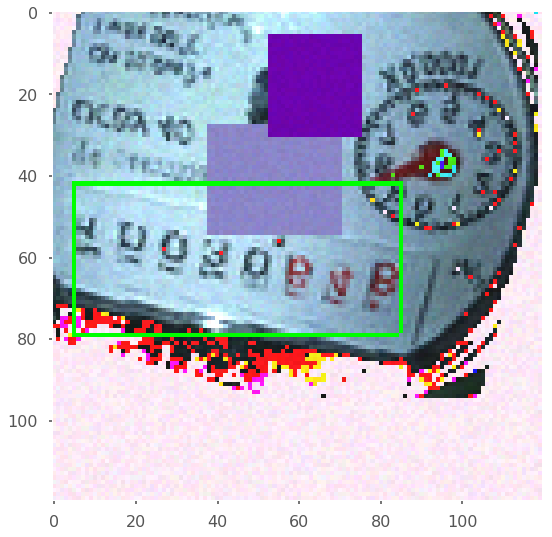

In [7]:
show_examples(train_load_ppl<<train_dset, 300, sleep_=0.01, width=2)

## test

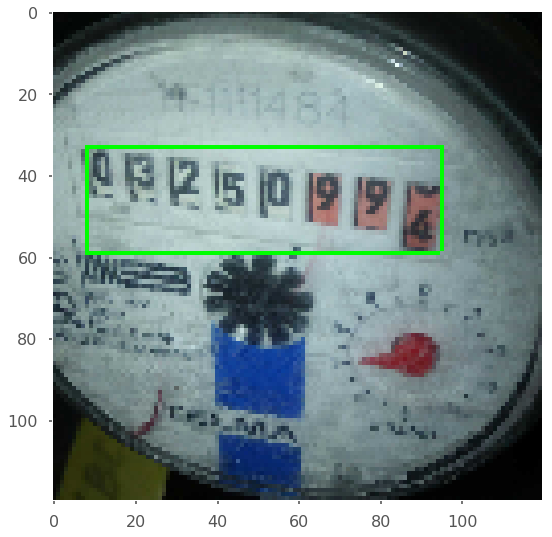

In [8]:
show_examples(test_load_ppl<<test_dset, 300, sleep_=0.01, width=2)

# Bounding box regression

In [5]:
import tensorflow as tf
def smooth_l1(labels, predictions, mu=0.3, scope=None, *args, **kwargs):
    error = predictions - labels
    abs_error = tf.abs(error)
    quadratic = tf.minimum(mu, error)
    losses = quadratic ** 2 / (2 * mu) + abs_error - quadratic
    return tf.reduce_mean(losses)

def dummy_huber(labels, predictions, delta=1.):
    
    return tf.losses.mean_squared_error(labels*np.array((1.5,1.5,1,1)), predictions*np.array((1.5,1.5,1,1)))

In [6]:
batch_size = 10
epoch_size=len(train_dset) // batch_size

# learning rate decat values
values = list(100*np.array([0.01, 0.001, 0.0001, 0.00005, 0.00001]))
boundaries = list((epoch_size * np.array([10, 20, 40, 400])).astype(np.int32))

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

train_ppl = (Pipeline()
         .init_variable('model_arch', MobileNet_v2)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={
                             'session' : {'config' : session_config},
                             'body': {'width_factor' : 1},
                             'inputs' : {'images': {'shape': B('image_shape'),
                                                    'data_format': 'channels_last'},
                                         'labels': {'name': 'targets', 'shape' : (4,)}},
                             'loss' : {'name' : 'huber', 'delta' : 1},
                             'decay' : {'name':"exp", "decay_rate" : 0.95, 'learning_rate' : 1.,\
                                        "decay_steps" : epoch_size, 'staircase' : True},
#                              'loss' : dummy_huber,
#                              'decay' : {'name' : 'const',
#                                         'boundaries' : boundaries,
#                                         'values' : values},
#                              'optimizer' : {'name' : 'GradientDescent',
                             'optimizer': {'name' : 'Momentum', 'momentum' : 0.99, 'use_nesterov' : True},
#                                            'learning_rate': 0.1},
                             'input_block/inputs' : 'images'})
           + train_load_ppl\
           + Pipeline()\
         .train_model('model', fetches=['loss', 'predictions'],
                      feed_dict={'images': B('images'),
                                 'labels': B('coordinates')},
                      save_to=[V('current_loss'), V('predictions')], use_lock=False)
         .iou()
        )
train_pipeline = train_ppl << train_dset




NameError: name 'train_dset' is not defined

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [ ]:
test_ppl =(Pipeline()\
         .import_model('model', train_pipeline)\
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)\
         + test_load_ppl + Pipeline()\
         .predict_model('model', fetches=['loss', 'predictions'],\
                      feed_dict={'images': B('images'),\
                                 'labels': B('coordinates')},\
                      save_to=[V('current_loss'), V('predictions')])
         .iou())
test_pipeline = test_ppl << test_dset

In [ ]:
def show_examples_val(ppl, a, width=2):
    for ai in a:
        batch = ppl.next_batch(1, shuffle=True, n_epochs=None)
        image = batch.images[0].copy()
        bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
        plt.figure(figsize=(9,9))
        image = add_bb(image, bbox, [0,1,0], width)
        bbox = ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2)
        image = add_bb(image, bbox, [1,0,0], width)
        ai.imshow(image);
        ai.set_title('iou: {:.2f}'.format(ppl.get_variable('current_iou')), fontsize=18)
        
        ai.grid(False);
        
def plot_metrics(loss, test_loss, iou, test_iou, show_img=False, ppl=None):
    if show_img==False:
        f, a = plt.subplots(1, 2, figsize=(16,9));
    else:
        f, a = plt.subplots(1, 2, figsize=(16, 5));
    x = np.arange(1, len(loss)+1)
    a = a.flatten()
    a[0].semilogy(x, loss, color='b', label='train')
    a[0].semilogy(x, test_loss, color='orange', label='test')
    a[0].legend()
    a[0].set_title('loss', fontsize=18)
    a[1].plot(x, iou, label='train', color='b')
    a[1].plot(x, test_iou, label='test', color='orange')
    a[1].legend()
    a[1].set_title('iou', fontsize=18)
    if show_img:
        f, a = plt.subplots(10, 3, figsize=(16, 64));
        show_examples_val(ppl, a.flatten());
    plt.show();
    print('-'*50)
    
def validate(ppl):
    iou, loss = 0, 0
    for i, tb in enumerate(ppl.gen_batch(batch_size=batch_size, n_epochs=1, drop_last=False), 1):
        iou += ppl.get_variable('current_iou')
        loss += ppl.get_variable('current_loss')
    return iou / i, loss / i

In [11]:
alpha = 1 / 100

iou_value = 0
loss_value = 0

losses = []
test_losses = []
iou_values = []
iou_test_values = []

best_iou = 0


log_file = 'train_log.txt'
with open(log_file, 'w') as f:
    f.write('each epoch lasts for {} iterations\n'.format(epoch_size))


for i, b in tqdm(enumerate(train_pipeline.gen_batch(batch_size=batch_size,
                                                    shuffle=True,
                                                    n_epochs=200,
                                                    drop_last=False,
                                                    prefetch=5), 1)):
    loss_value = (1 - alpha) * loss_value + alpha * train_pipeline.get_variable('current_loss')
    iou_value = (1 - alpha) * iou_value + alpha * train_pipeline.get_variable('current_iou')
    
    if i % 10 == 0 and i < 51:
         print(i, 'train loss: {:.1e}'.format(loss_value), 'train iou: {:.2f}'.format(iou_value))
            
    if i % (epoch_size // 10) == 0:
        losses.append(loss_value)
        iou_values.append(iou_value)

        iou, loss = validate(test_pipeline)
        iou_test_values.append(iou)
        test_losses.append(loss)
        
        clear_output(True)
        log = 'epoch {0:d}.{1:d}: train loss: {2:.2e}, test loss: {3:.2e}, train iou: {4:.2f}, test iou: {5:.2f}\n'\
            .format(i // epoch_size, int((i % epoch_size) * 10 / epoch_size),\
                    loss_value, test_losses[-1],\
                    iou_value, iou_test_values[-1])
            
        with open(log_file, 'a') as f:
            f.write(log)
            
        if iou_test_values[-1] > best_iou:
            best_iou = iou_test_values[-1]
            for file in os.listdir('models'):
                file_path = os.path.join('models', file)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            train_pipeline.save(name='model', path='models/')
            
        plot_metrics(losses, test_losses, iou_values, iou_test_values, show_img=True, ppl=test_pipeline);

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


IndexError: index 967 is out of bounds for axis 0 with size 497

array([[0., 0., 0.]])

In [24]:
from numba import njit
import numpy as np

@njit(nogil=True)
def get_nodules_numba(data, positions, size):
    size = size.astype(np.int32)
    out_arr = np.zeros((positions.shape[0], size[0], size[1], size[2]))

    n_positions = positions.shape[0]
    for i in range(n_positions):
        out_arr[i, :, :, :] = data[positions[i, 0]: positions[i, 0] + size[0],
                                   positions[i, 1]: positions[i, 1] + size[1],
                                   positions[i, 2]: positions[i, 2] + size[2]]

    return out_arr.reshape(n_positions * size[0], size[1], size[2]), size.dtype

dat = np.linspace(0, 1, 60).reshape(3, 4, 5)
pos = np.array([[0, 1, 1], [1, 2, 2]])
sz = np.array([2, 2, 2])
print(dat.dtype, pos.dtype, sz.dtype)
get_nodules_numba(dat, pos, sz)

float64 int64 int64


LoweringError: Failed at nopython (nopython mode backend)
Operands must be the same type, got (i64, i32)
File "<ipython-input-24-b07053b35198>", line 7
[1] During: lowering "$0.22 = call $0.7($0.21, func=$0.7, vararg=None, args=[Var($0.21, <ipython-input-24-b07053b35198> (7))], kws=[])" at <ipython-input-24-b07053b35198> (7)

In [20]:
show_examples(test_pipeline, n=100, sleep_=0.2, test=True, width=2)

NameError: name 'test_pipeline' is not defined

# Load model from a file

In [19]:
images_uber_test = np.stack([resize(imread('/home/grisha/Desktop/all_new_meters/voda_20171102/'+x), (120,120))
                             for x in sorted(os.listdir('/home/grisha/Desktop/all_new_meters/voda_20171102/'))])

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/grisha/Desktop/all_new_meters/47f9fe6976fb53e8ad7425345d1546361.png
/home/grisha/Desktop/all_new_meters/47f9fe6976fb53e8ad7425345d1546361.JPEG
/home/grisha/Desktop/all_new_meters/47f9fe6976fb53e8ad7425345d1546361.jpg
/home/grisha/Desktop/all_new_meters/47f9fe6976fb53e8ad7425345d1546361.jpeg
/home/grisha/Desktop/all_new_meters/47f9fe6976fb53e8ad7425345d1546361.JPG


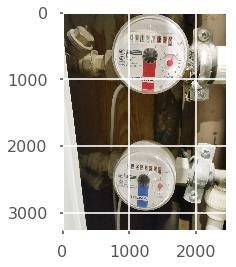

In [26]:
from meters.dataset.dataset.models.tf import TFModel
uber_dset = Dataset(index=FilesIndex(path='/home/grisha/Desktop/all_new_meters/*', no_ext=True), batch_class=MeterBatch)
pipeline = Pipeline().load(src='/home/grisha/Desktop/all_new_meters/', fmt='image',components='images') << uber_dset


uber_test_load_ppl = \
    Pipeline()\
    .load(src='/home/grisha/Desktop/all_new_meters/', fmt='image',components='images')\
    .resize((120, 120))\
    .multiply(multiplier=1/255., preserve_type=False)

uber_test_ppl =(Pipeline()\
         .init_model('dynamic', TFModel, 'model',
                     config={'load' : {'path' : './models'},
                             'build': False})
         .init_variable('predictions', init_on_each_run=0)\
         + uber_test_load_ppl + Pipeline()\
         .predict_model('model', fetches=['predictions'],\
                        feed_dict={'images': B('images')},\
                        save_to=[ V('predictions')]))
uber_test_pipeline = uber_test_ppl << uber_dset

/home/grisha/Desktop/all_new_meters/bf539f3af00c5712a3fec2b6535f12ec4.png
/home/grisha/Desktop/all_new_meters/bf539f3af00c5712a3fec2b6535f12ec4.JPEG
/home/grisha/Desktop/all_new_meters/bf539f3af00c5712a3fec2b6535f12ec4.jpg
/home/grisha/Desktop/all_new_meters/bf539f3af00c5712a3fec2b6535f12ec4.jpeg


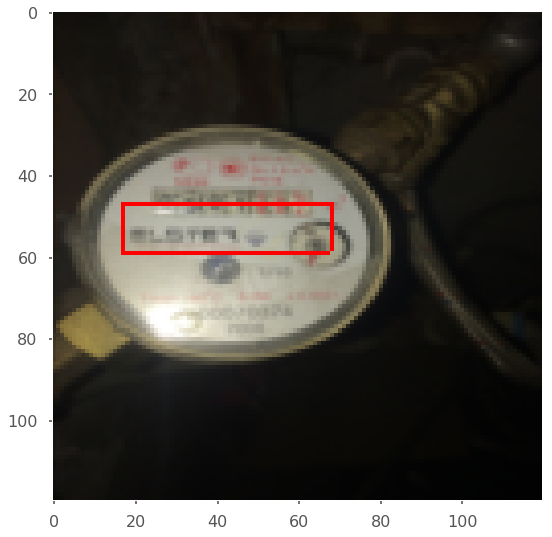

KeyboardInterrupt: 

In [29]:
show_examples(uber_test_pipeline, n=100, sleep_=1, real=False, test=True, width=2)